In [16]:
from openai import OpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import List, Optional, Dict
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np
import yaml
import pandas as pd
import os
load_dotenv()
client = OpenAI()
import random
from multiprocessing import Pool

TRIALS = 125
#MODEL = "gpt-4o-mini-2024-07-18"
MODEL = "gpt-4o-mini"
PROMPT_SYSTEM_PATH = './prompts/system_prompt_2.txt'
PROMPT_PAIR_PATH = './prompts/play_for_pair_4_1.txt'
PROMPT_SELF_PATH = './prompts/play_for_self_4_1.txt'
RANDOM_AGENT=False

In [17]:

class GameEvent(BaseModel):
    stag: bool
    reasoning: str

class History(BaseModel):
    name: str
    stag: bool
    period: int
    payoff: int

class Games(BaseModel):
    event: List[GameEvent] = Field(default_factory=list)

class GameHistory(BaseModel):
    history: List[History] = Field(default_factory=list)

def run_agent_decision(system_prompt, game_prompt, name=None, model=MODEL, response_format=GameEvent):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": game_prompt}
    ]
    try:
        response = client.beta.chat.completions.parse(
            model=model, 
            messages=messages,
            response_format=response_format
            )
        results = response_format.model_validate_json(response.choices[0].message.content).model_dump()
        #print(f"{name} ({results['stag']}): {results['reasoning']}")
        results['name'] = name
        results['model'] = model
        return results
    except Exception as e:
        raise e


In [18]:
def get_random_decision():
    choice = {"stag": random.choice([True, False]), "reasoning": "random"}
    #print(f"Chose {choice['stag']} randomly")
    return choice

In [19]:
def get_mixed_strat():
    rng = random.random()
    if rng < 7/8:
        choice = {"stag": True, "reasoning": "mixed"}
    else:
        choice = {"stag": False, "reasoning": "mixed"}
    #print(f"Chose {choice['stag']} randomly")
    return choice

In [20]:
sum = 0
for _ in range(10_000):
    sum += int(np.random.choice([True, False]))
sum/10_000

0.5032

In [21]:
PAYOFF_HIGH = 9
PAYOFF_MID  = 8
PAYOFF_LOW  = 1
PROMPT_SYSTEM = open(PROMPT_SYSTEM_PATH,'r').read()
PROMPT_PAIR = open(PROMPT_PAIR_PATH,'r').read()
PROMPT_SELF = open(PROMPT_SELF_PATH,'r').read()

def calculate_payoff(round_events):
    payoffs = {}
    name_1,name_2 = list(round_events.keys())
    decision_1 = round_events[name_1]['stag']
    decision_2 = round_events[name_2]['stag']
    if decision_1 and decision_2:
        payoffs[name_1] = PAYOFF_HIGH
        payoffs[name_2] = PAYOFF_HIGH
    elif decision_1 and not decision_2:
        payoffs[name_1] = PAYOFF_LOW
        payoffs[name_2] = PAYOFF_MID
    elif not decision_1 and decision_2:
        payoffs[name_1] = PAYOFF_MID
        payoffs[name_2] = PAYOFF_LOW
    else:
        payoffs[name_1] = PAYOFF_MID
        payoffs[name_2] = PAYOFF_MID
    return payoffs

def get_game_summary(name, histories):
    if len(histories) == 0:
        return ""
    summary = "# Previous Game Summaries\n"
    for round, round_events in enumerate(histories):
        summary += f"## Round {round}\n"
        for _, event in round_events.items():
            _name = "You" if event.name == name else event.name
            _selection = "Stag" if event.stag else "Hare"
            summary += f"- {_name} selected {_selection} and received a payoff of {event.payoff}\n"
        summary += "\n"
    return summary

def run_session(rounds, player_names, system_prompt, prompt, strat=None):
    histories = []
    for round in range(rounds):
        round_events = {}
        decisions = {}
        for i,name in enumerate(player_names):
            game_summary = get_game_summary(name, histories)
            #print(prompt + game_summary)
            if strat is not None and i > 0:
                decisions[name] = strat()
            else:
                decisions[name] = run_agent_decision(system_prompt, prompt + game_summary, name)
        
        payoffs = calculate_payoff(decisions)
        
        for name, decision_result in decisions.items():
            event = History(name=name, stag=decision_result['stag'], period=round, payoff=payoffs[name])
            round_events[name] = event
            
        histories.append(round_events)
    return histories

def get_df_from_history(all_histories):
    data = []
    print(all_histories)
    for round, histories in enumerate(all_histories):
        for name,history in histories.items():
            data.append({
                'player': name,
                'period': history.period,
                'stag': history.stag,
                'payoff': history.payoff
            })
    return pd.DataFrame(data)

def run_session_play_for_pair(rounds=15, strat=get_mixed_strat):
    if RANDOM_AGENT == True:
        strat = get_random_decision
    player_names = ['Team1','Team2']
    system_prompt = PROMPT_SYSTEM
    prompt = PROMPT_PAIR
    
    all_histories = run_session(rounds, player_names, system_prompt, prompt, strat)
    return get_df_from_history(all_histories)
        
def run_session_play_for_self(rounds=15, strat=get_mixed_strat):
    if RANDOM_AGENT == True:
        strat = get_random_decision
    player_names = ['Player1', 'Player2']
    system_prompt = PROMPT_SYSTEM
    prompt = PROMPT_SELF
    
    all_histories = run_session(rounds, player_names, system_prompt, prompt, strat)
    return get_df_from_history(all_histories)

In [22]:
run_session_play_for_pair(1, get_random_decision)

[{'Team1': History(name='Team1', stag=True, period=0, payoff=1), 'Team2': History(name='Team2', stag=False, period=0, payoff=8)}]


,player,period,stag,payoff
0,Team1,0,True,1
1,Team2,0,False,8


In [23]:
run_session_play_for_self(1, get_random_decision)

[{'Player1': History(name='Player1', stag=True, period=0, payoff=9), 'Player2': History(name='Player2', stag=True, period=0, payoff=9)}]


,player,period,stag,payoff
0,Player1,0,True,9
1,Player2,0,True,9


In [24]:
with Pool(20) as p:
    results_pair = p.map(run_session_play_for_pair, [15]*TRIALS)
pp_df = pd.concat(results_pair)
print(pp_df['stag'].mean())
pp_df

[{'Team1': History(name='Team1', stag=True, period=0, payoff=9), 'Team2': History(name='Team2', stag=True, period=0, payoff=9)}, {'Team1': History(name='Team1', stag=True, period=1, payoff=9), 'Team2': History(name='Team2', stag=True, period=1, payoff=9)}, {'Team1': History(name='Team1', stag=True, period=2, payoff=9), 'Team2': History(name='Team2', stag=True, period=2, payoff=9)}, {'Team1': History(name='Team1', stag=True, period=3, payoff=9), 'Team2': History(name='Team2', stag=True, period=3, payoff=9)}, {'Team1': History(name='Team1', stag=True, period=4, payoff=9), 'Team2': History(name='Team2', stag=True, period=4, payoff=9)}, {'Team1': History(name='Team1', stag=True, period=5, payoff=1), 'Team2': History(name='Team2', stag=False, period=5, payoff=8)}, {'Team1': History(name='Team1', stag=True, period=6, payoff=9), 'Team2': History(name='Team2', stag=True, period=6, payoff=9)}, {'Team1': History(name='Team1', stag=True, period=7, payoff=9), 'Team2': History(name='Team2', stag=Tr

,player,period,stag,payoff
0,Team1,0,True,9
1,Team2,0,True,9
2,Team1,1,True,9
3,Team2,1,True,9
4,Team1,2,True,9
...,...,...,...,...
25,Team2,12,True,9
26,Team1,13,True,9
27,Team2,13,True,9
28,Team1,14,True,9


In [25]:

with Pool(20) as p:
    results_self = p.map(run_session_play_for_self, [15]*TRIALS)
ps_df = pd.concat(results_self)
print(ps_df['stag'].mean())
ps_df

[{'Player1': History(name='Player1', stag=True, period=0, payoff=1), 'Player2': History(name='Player2', stag=False, period=0, payoff=8)}, {'Player1': History(name='Player1', stag=False, period=1, payoff=8), 'Player2': History(name='Player2', stag=True, period=1, payoff=1)}, {'Player1': History(name='Player1', stag=False, period=2, payoff=8), 'Player2': History(name='Player2', stag=False, period=2, payoff=8)}, {'Player1': History(name='Player1', stag=False, period=3, payoff=8), 'Player2': History(name='Player2', stag=True, period=3, payoff=1)}, {'Player1': History(name='Player1', stag=True, period=4, payoff=9), 'Player2': History(name='Player2', stag=True, period=4, payoff=9)}, {'Player1': History(name='Player1', stag=True, period=5, payoff=1), 'Player2': History(name='Player2', stag=False, period=5, payoff=8)}, {'Player1': History(name='Player1', stag=True, period=6, payoff=9), 'Player2': History(name='Player2', stag=True, period=6, payoff=9)}, {'Player1': History(name='Player1', stag=

,player,period,stag,payoff
0,Player1,0,False,8
1,Player2,0,True,1
2,Player1,1,False,8
3,Player2,1,True,1
4,Player1,2,False,8
...,...,...,...,...
25,Player2,12,False,8
26,Player1,13,False,8
27,Player2,13,True,1
28,Player1,14,False,8


In [26]:
import time

timestamp = int(time.time())


path_info = {
    'system path': PROMPT_SYSTEM_PATH,
    'pair path': PROMPT_PAIR_PATH,
    'self path': PROMPT_SELF_PATH
}
metadata = {
    'time': timestamp,
    'number of rounds': TRIALS,
    'number ow rows': len(pp_df),
    'random agent': RANDOM_AGENT,
    'model used': MODEL,
    'game model': vars(GameEvent)['__annotations__'],
    'path_info': path_info,
    'prompts':
    {
        'system': PROMPT_SYSTEM,
        'pair': PROMPT_PAIR,
        'self': PROMPT_SELF
    }
    
}
filename = f'./dist/notes_{int(timestamp)}.yaml'

# Write metadata in yaml format
with open(filename, 'w') as file:
    documents = yaml.dump(metadata, file)
    
pp_df.to_csv(f'./dist/pp_df_{int(timestamp)}.csv', index=False)
ps_df.to_csv(f'./dist/ps_df_{int(timestamp)}.csv', index=False)

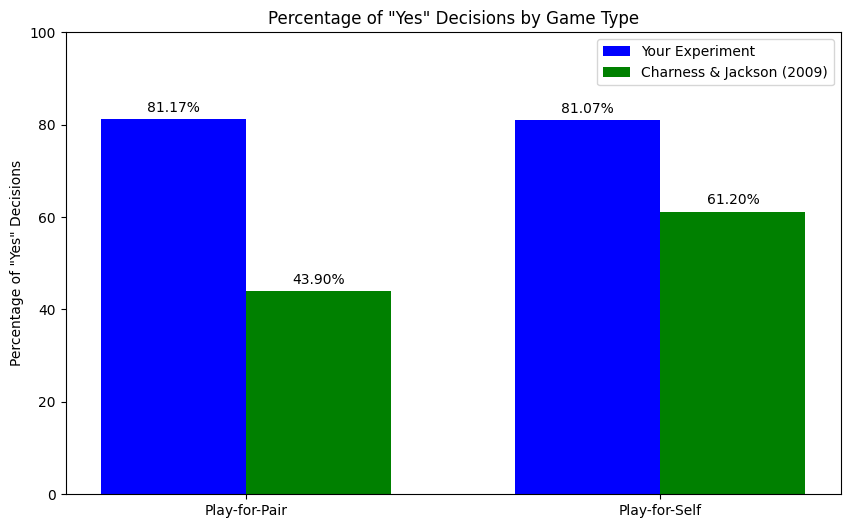

In [27]:
## Percentages

# Play-for-Pair
pp_total_decisions = len(pp_df)
pp_yes_decisions = pp_df[pp_df['stag'] == True].shape[0]
pp_percentage_yes = (pp_yes_decisions / pp_total_decisions) * 100

# Play-for-Self
ps_total_decisions = len(ps_df)
ps_yes_decisions = ps_df[ps_df['stag'] == True].shape[0]
ps_percentage_yes = (ps_yes_decisions / ps_total_decisions) * 100

# Your experiment's percentages
your_percentages = [pp_percentage_yes, ps_percentage_yes]

# Papers Results
paper_pp_percentage = 43.9
paper_ps_percentage = 61.2

paper_percentages = [paper_pp_percentage, paper_ps_percentage]

# Data for plotting
game_types = ['Play-for-Pair', 'Play-for-Self']
x = np.arange(len(game_types))  # the label locations
width = 0.35  # the width of the bars

# Create the bar chart
plt.figure(figsize=(10, 6))
rects1 = plt.bar(x - width/2, your_percentages, width, label='Your Experiment', color=['blue'])
rects2 = plt.bar(x + width/2, paper_percentages, width, label='Charness & Jackson (2009)', color=['green'])

# Add percentage labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.2f}%',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Chart formatting
plt.title('Percentage of "Yes" Decisions by Game Type')
plt.ylabel('Percentage of "Yes" Decisions')
plt.xticks(x, game_types)
plt.ylim(0, 100)
plt.legend()

plt.show()


In [28]:
pp_df

,player,period,stag,payoff
0,Team1,0,True,9
1,Team2,0,True,9
2,Team1,1,True,9
3,Team2,1,True,9
4,Team1,2,True,9
...,...,...,...,...
25,Team2,12,True,9
26,Team1,13,True,9
27,Team2,13,True,9
28,Team1,14,True,9


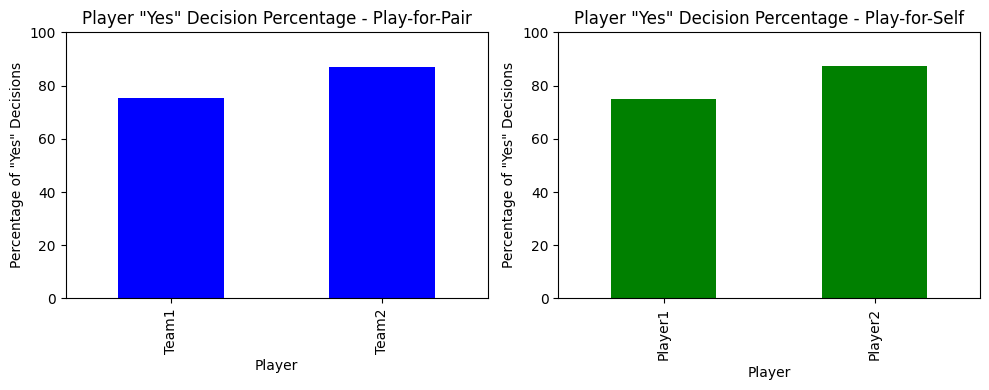

In [29]:
# Calculate percentage of "Yes" decisions per player for Play-for-Pair
pp_player_percentages = pp_df.groupby('player')['stag'].mean() * 100

# Calculate percentage of "Yes" decisions per player for Play-for-Self
ps_player_percentages = ps_df.groupby('player')['stag'].mean() * 100

# Plotting for Play-for-Pair
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
pp_player_percentages.plot(kind='bar', color='blue')
plt.title('Player "Yes" Decision Percentage - Play-for-Pair')
plt.xlabel('Player')
plt.ylabel('Percentage of "Yes" Decisions')
plt.ylim(0, 100)

# Plotting for Play-for-Self
plt.subplot(1, 2, 2)
ps_player_percentages.plot(kind='bar', color='green')
plt.title('Player "Yes" Decision Percentage - Play-for-Self')
plt.xlabel('Player')
plt.ylabel('Percentage of "Yes" Decisions')
plt.ylim(0, 100)

plt.tight_layout()
plt.show()


In [30]:
print(pp_df['payoff'].value_counts())
print(ps_df['payoff'].value_counts())

payoff
9    2448
8     706
1     596
Name: count, dtype: int64
payoff
9    2462
8     710
1     578
Name: count, dtype: int64
